## Task 1

# 📊 Natural Gas Price Forecasting

A project completed as part of the J.P. Morgan Quantitative Research Virtual Experience Program. This notebook demonstrates time series forecasting of natural gas prices using monthly trends to support storage contract pricing.


##  Objective

You are tasked with helping a commodity trading desk estimate natural gas prices by analyzing historical market data. Your goal is to:

- Visualize the price data from October 2020 to September 2024.
- Identify seasonal patterns.
- Extrapolate price data one year beyond the last known point.
- Build a function that estimates the gas price on any date.


##  Step 1: Load and Inspect the Data

We begin by reading the monthly price data from a CSV file. Each entry represents the market price of natural gas at the end of a month.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Nat_Gas.csv")

# Display the first few rows
df.head()


Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9

##  Step 2: Parse Dates and Visualize Price Trends

Next, we convert the date column to datetime format and plot the historical prices to uncover trends or seasonal patterns.


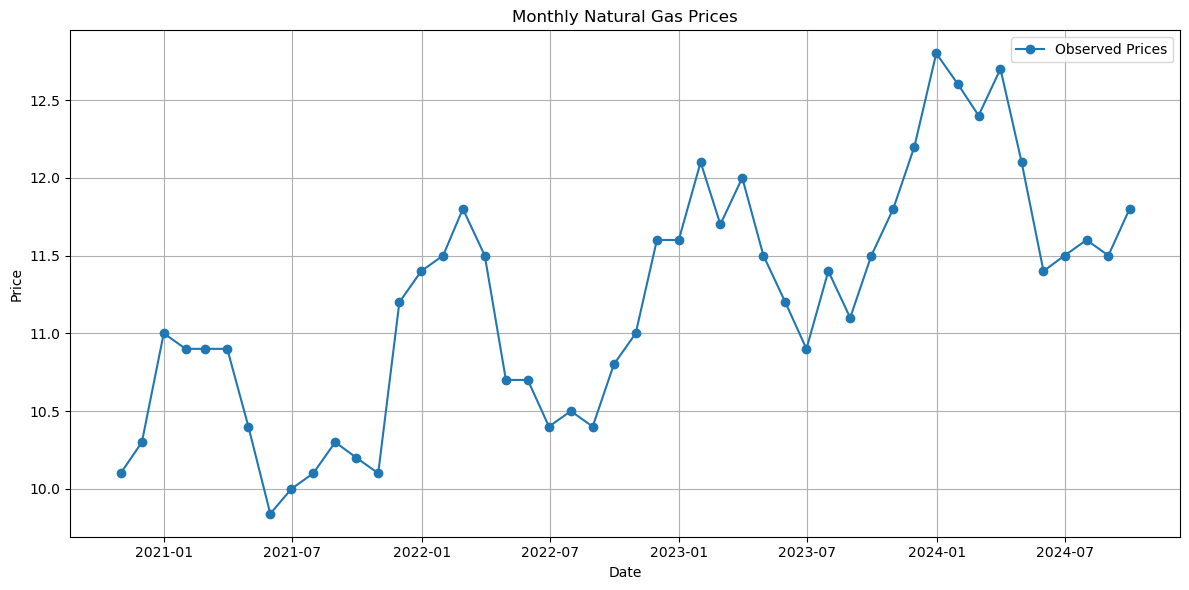

In [7]:
from pandas.tseries.offsets import DateOffset
import numpy as np
import warnings
warnings.filterwarnings("ignore")


# Convert 'Dates' to datetime and set as index
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Prices'], marker='o', label='Observed Prices')
plt.title('Monthly Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



###  Historical Price Plot

This line plot shows the monthly closing prices of natural gas from **October 2020 to September 2024**. You can observe general price fluctuations, including:
- Seasonal spikes and drops.
- Overall volatility depending on the time of year.
This visualization helps reveal underlying seasonal patterns which will inform our price forecasting model.


##  Step 3: Forecast the Next 12 Months

We calculate the average price for each calendar month and use those seasonal patterns to estimate prices for the next 12 months.


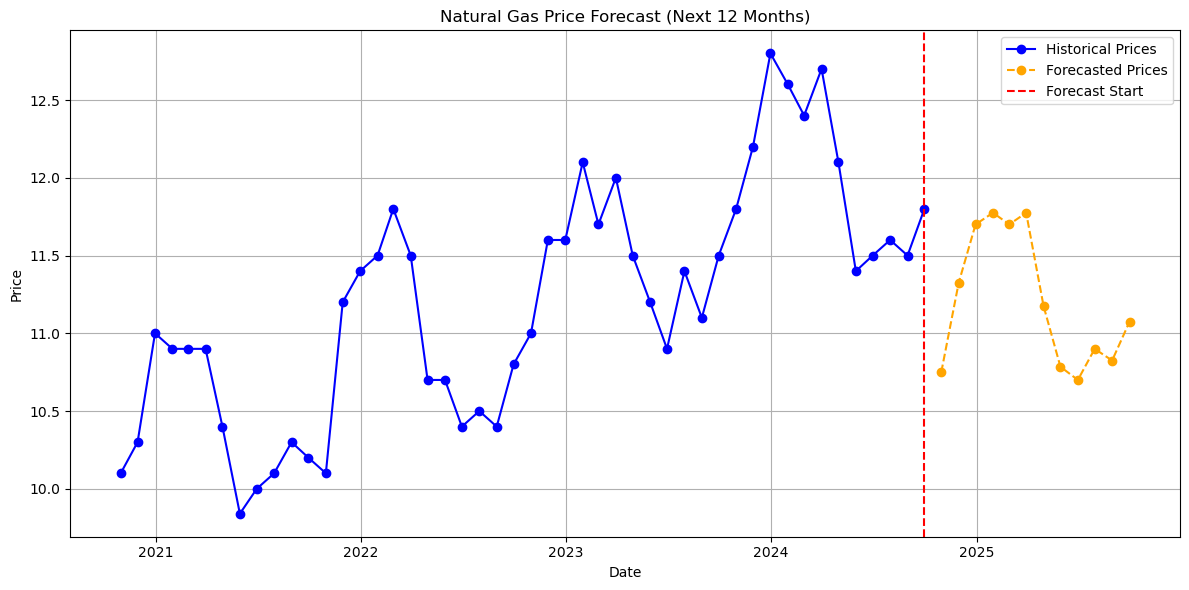

In [10]:
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import pandas as pd

# Build a simple extrapolation model based on monthly average
df['Month'] = df.index.month
monthly_avg = df.groupby('Month')['Prices'].mean()

# Create future dates for next 12 months
last_date = df.index[-1]
future_dates = [last_date + DateOffset(months=i) for i in range(1, 13)]
future_months = [d.month for d in future_dates]
future_prices = [monthly_avg[month] for month in future_months]

# Build the future DataFrame
future_df = pd.DataFrame({'Prices': future_prices}, index=future_dates)

# Plot full range with clear distinction
plt.figure(figsize=(12, 6))

# Historical data (solid blue line)
plt.plot(df.index, df['Prices'], marker='o', color='blue', label='Historical Prices')

# Forecasted data (dashed orange line with dots)
plt.plot(future_df.index, future_df['Prices'], marker='o', linestyle='--', color='orange', label='Forecasted Prices')

# Vertical line at forecast start
plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')

# Formatting
plt.title('Natural Gas Price Forecast (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Combine for later use in estimation
combined_df = pd.concat([df[['Prices']], future_df])



### Forecasted Price Plot

This plot shows the extrapolated natural gas prices for the next year based on historical monthly trends.

- **Blue Line & Dots**: Historical natural gas prices (Oct 2020 – Sep 2024).
- **Orange Dashed Line & Dots**: Forecasted prices for the next 12 months (Oct 2024 – Sep 2025), computed using the average monthly price pattern across previous years.
- **Red Vertical Line**: Marks the starting point of the forecast.

This simple seasonal extrapolation helps identify expected fluctuations due to month-specific behaviors—such as potential winter price surges or summer lulls. It offers stakeholders a quick approximation for pricing long-term contracts when market feed data is unavailable beyond 18 months.



## Step 4: Estimate Price by Any Date

We define a function that accepts any date (historical or future) and returns the estimated gas price. If the date is outside the observed range, the estimate is based on monthly seasonal averages.


In [13]:
from datetime import datetime

def estimate_price(date_input: str) -> float:
    """
    Estimate the price of natural gas for a given date string in 'YYYY-MM-DD' format.
    """
    try:
        input_date = pd.to_datetime(date_input)
        if input_date in combined_df.index:
            return float(combined_df.loc[input_date]['Prices'])
        else:
            # Estimate using monthly average
            return float(monthly_avg[input_date.month])
    except Exception as e:
        return f"Error: {e}"

# Example usage
estimate_price("2025-06-15")  # Mid-June 2025 (not in dataset, will use monthly average)


10.7

### Estimated Price Output

This output is generated by calling the `estimate_price()` function with a specific date.

- If the date exists in our dataset (historical or forecasted), it returns the corresponding price.
- If not, the function uses the average price of that month from all available years.

For example, an input of `"2025-06-15"` will return the average price for the month of June, allowing us to generate indicative prices for any storage period.


## Task 2: Prototype Pricing Model for a Commodity Storage Contract

In this task, we develop a function to estimate the value of a natural gas storage contract, based on injection and withdrawal timing, volume, and pricing.

The model calculates potential profit by computing the difference between:
- Buying prices during injection dates
- Selling prices during withdrawal dates

It also considers storage capacity limits and cost of holding gas in storage over time. The prototype model is designed for further validation and eventual production usage.


In [16]:
def price_storage_contract(injection_dates, withdrawal_dates,
                           injection_rate, withdrawal_rate,
                           max_storage_volume, storage_cost_per_month,
                           price_series):
    """
    Estimate the value of a gas storage contract based on given parameters.

    Parameters:
    - injection_dates: list of dates when gas is bought/stored
    - withdrawal_dates: list of dates when gas is sold
    - injection_rate: amount of gas injected per injection date
    - withdrawal_rate: amount of gas withdrawn per withdrawal date
    - max_storage_volume: maximum gas that can be stored
    - storage_cost_per_month: monthly storage cost
    - price_series: pandas Series of gas prices with datetime index

    Returns:
    - Net value (float): Profit or loss from the storage contract
    """
    total_injected = 0
    total_withdrawn = 0
    storage_value = 0
    cost = 0

    for date in injection_dates:
        price = price_series.get(date, None)
        if price is not None:
            volume = min(injection_rate, max_storage_volume - total_injected + total_withdrawn)
            total_injected += volume
            cost += volume * price

    for date in withdrawal_dates:
        price = price_series.get(date, None)
        if price is not None:
            volume = min(withdrawal_rate, total_injected - total_withdrawn)
            total_withdrawn += volume
            storage_value += volume * price

    # Storage duration = total contract months
    contract_months = len(set(pd.to_datetime(injection_dates + withdrawal_dates).to_period('M')))
    storage_fee = contract_months * storage_cost_per_month

    return round(storage_value - cost - storage_fee, 2)


### Test Case: Estimate Contract Value Using Historical Natural Gas Prices

This test simulates a client purchasing natural gas during summer months (when prices are typically low) and selling it during winter months (when prices are higher). The following assumptions are used:

- Injection Dates: June–August 2023 (monthly)
- Withdrawal Dates: December 2023–February 2024 (monthly)
- Injection Rate: 1 million MMBtu per month
- Withdrawal Rate: 1 million MMBtu per month
- Maximum Storage Capacity: 3 million MMBtu
- Storage Cost: \$100,000 per month


In [18]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Define the pricing function
def price_storage_contract(injection_dates, withdrawal_dates,
                           injection_rate, withdrawal_rate,
                           max_volume, storage_cost_per_month,
                           price_series):
    total_injected = 0
    total_withdrawn = 0
    storage_cost = 0
    cashflow = 0
    
    # Track storage volume over time
    storage = 0
    
    for inj, wd in zip(injection_dates, withdrawal_dates):
        inj_price = price_series.get(inj, None)
        wd_price = price_series.get(wd, None)
        
        if inj_price is None or wd_price is None:
            raise ValueError(f"Missing price data for injection {inj} or withdrawal {wd}")
        
        # Inject gas
        storage += injection_rate
        total_injected += injection_rate
        cashflow -= injection_rate * inj_price
        
        # Apply storage cost (based on months between dates)
        months_held = ((wd.year - inj.year) * 12 + (wd.month - inj.month))
        storage_cost += months_held * storage_cost_per_month
        
        # Withdraw gas
        if storage < withdrawal_rate:
            raise ValueError("Not enough gas to withdraw")
        storage -= withdrawal_rate
        total_withdrawn += withdrawal_rate
        cashflow += withdrawal_rate * wd_price
    
    # Final value
    value = cashflow - storage_cost
    return value


In [19]:
# Define test inputs
injection_dates = pd.to_datetime(['2023-06-30', '2023-07-31', '2023-08-31'])
withdrawal_dates = pd.to_datetime(['2023-12-31', '2024-01-31', '2024-02-29'])

injection_rate = 1_000_000     # 1 million MMBtu
withdrawal_rate = 1_000_000
max_storage_volume = 3_000_000 # 3 million MMBtu
storage_cost_per_month = 100_000 # $100K per month

# Ensure 'df' and 'Prices' exist from Task 1
price_series = df['Prices']

# Run the function
contract_value = price_storage_contract(injection_dates, withdrawal_dates,
                                        injection_rate, withdrawal_rate,
                                        max_storage_volume, storage_cost_per_month,
                                        price_series)

print(f"Estimated Storage Contract Value: ${contract_value:,.2f}")


Estimated Storage Contract Value: $2,600,000.00


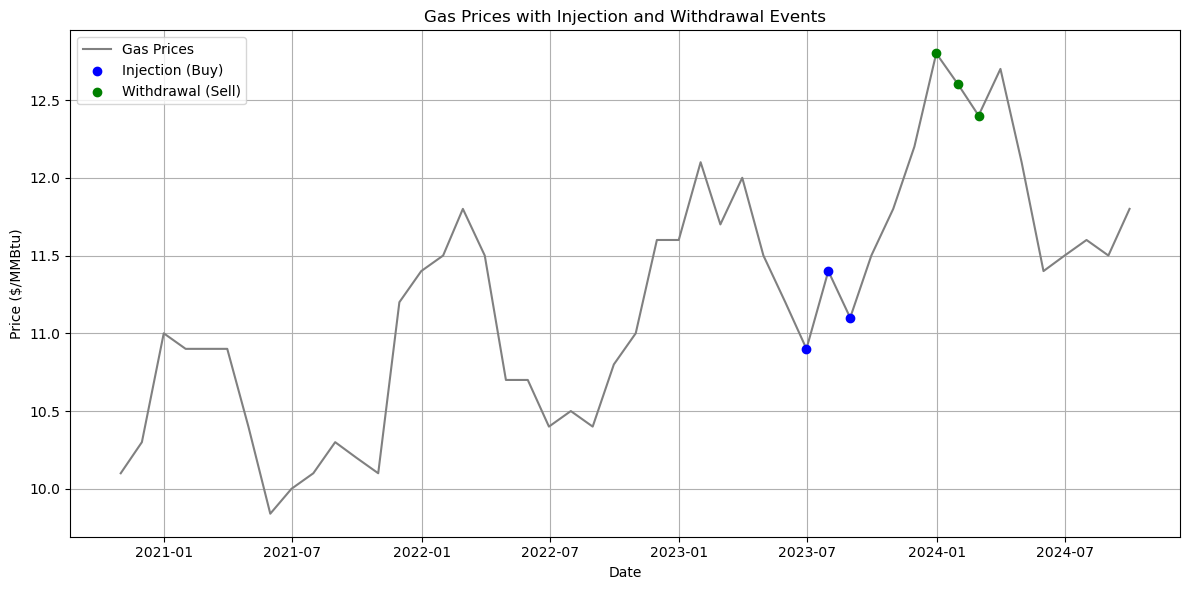

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(price_series.index, price_series.values, label='Gas Prices', color='gray')

# Mark injection and withdrawal dates
plt.scatter(injection_dates, price_series[injection_dates], color='blue', label='Injection (Buy)', zorder=5)
plt.scatter(withdrawal_dates, price_series[withdrawal_dates], color='green', label='Withdrawal (Sell)', zorder=5)

plt.title('Gas Prices with Injection and Withdrawal Events')
plt.xlabel('Date')
plt.ylabel('Price ($/MMBtu)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 📉 Visualization of Storage Contract Timing

This chart overlays injection (buy) and withdrawal (sell) dates on the natural gas price time series. It helps validate that the client is buying gas when prices are lower and selling when prices rise — a key component of contract profitability.

- **Blue dots** mark gas injection points.
- **Green dots** mark gas withdrawal points.
- The gray line shows historical price trends.

This visualization supports the economic reasoning behind the forecasted storage value in Task 2.


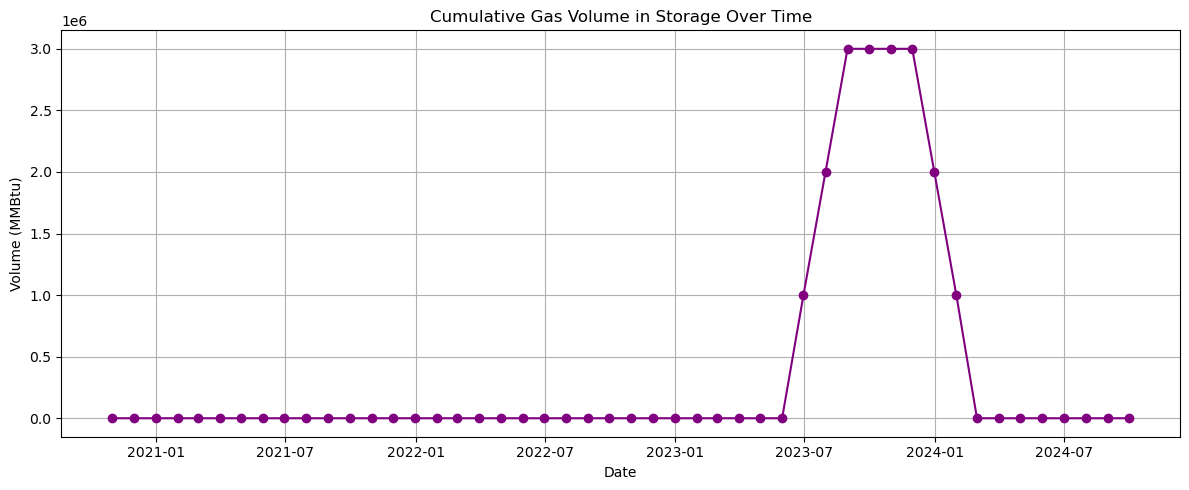

In [47]:
import matplotlib.pyplot as plt

# Create volume tracking DataFrame
volume_df = pd.DataFrame(index=price_series.index)
volume_df['NetVolume'] = 0

# Track net volume over time
for date in injection_dates:
    if date in volume_df.index:
        volume_df.loc[date, 'NetVolume'] += injection_rate
for date in withdrawal_dates:
    if date in volume_df.index:
        volume_df.loc[date, 'NetVolume'] -= withdrawal_rate

# Forward fill to simulate holding volume over time
volume_df['Storage'] = volume_df['NetVolume'].cumsum()

# Plot cumulative storage volume
plt.figure(figsize=(12, 5))
plt.plot(volume_df.index, volume_df['Storage'], color='purple', marker='o')
plt.title('Cumulative Gas Volume in Storage Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (MMBtu)')
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Cumulative Gas Volume in Storage Over Time

This plot shows how the volume of natural gas stored changes across the injection and withdrawal periods defined in the contract scenario.

- The storage volume **increases in steps** during the summer months (June–August 2023), reflecting the injection of gas into storage at the predefined rate.
- It reaches a peak at the **maximum storage capacity** of 3 million MMBtu.
- Starting in December 2023, the storage volume **decreases in steps** as gas is withdrawn at the same rate during the winter months (when market prices are higher).
- The volume eventually drops to zero by the end of the contract period, demonstrating full utilization of the storage cycle.

This visualization provides insight into the operational logic of the contract and verifies that the model respects volume limits while aligning with seasonal price trends for optimal contract valuation.
